In [1]:
import nlopt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import copy
from osclib import osclibrary as osc

np.seterr(divide='ignore', invalid='ignore')

plt.rcParams.update({
#     "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 14
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

In [2]:
xraypath = '/Users/olgaridzel/Research/Bruce/PHYSDAT/opt/xray/'

In [3]:
def vec2Struct(osc_vec):
    aomgam = np.split(osc_vec,3)
    osc = copy.deepcopy(osc_global)
    osc.A = aomgam[0]
    osc.gamma = aomgam[1]
    osc.omega = aomgam[2]
    return osc

def struct2Vec(osc_struct):
    return np.hstack((osc_struct.A,osc_struct.gamma,osc_struct.omega))

def objective_function(osc_vec, grad):
    osc_f = vec2Struct(osc_vec)
    inelastic = osc.InelasticProperies(osc_f)
    eloss, ndiimfp = inelastic.calculateDIIMFP(E0_global, 11)
    diimfp_interp = np.interp(x_exp,eloss,ndiimfp)
    chi_squared = np.sum((y_exp - diimfp_interp)**2)

    if grad.size > 0:
        grad = np.array([0,0.5/chi_squared])
    return chi_squared

def constraint_function(osc_vec, grad):
    osc_fc = vec2Struct(osc_vec)
    osc_fc.convert2au()
    if osc_fc.model == 'Drude':
        cf = osc_fc.electron_density * osc.wpc / np.sum(osc_fc.A)
    else:
        cf = (1 - 1/osc_fc.refractive_index**2) / np.sum(osc_fc.A)
    val = np.fabs(cf-1)

    if grad.size > 0:
        grad = np.array([0,0.5/val])
    
    return val

FileNotFoundError: [Errno 2] No such file or directory: '../Michael/pmma/pmma.dat'

In [4]:
A = [2.88,17.04,25.53,2.48,30.87,17.34,27.94,23,23.48,22.85,20.23,25.42,29,17.28,65.7,12.84,32.66,6.22]
gamma = [1.2,2,1.9,1.8,2.5,2.2,2.9,3.6,3.9,5,6.1,15.6,8.2,7.6,73.3,6.9,14.3,6.8]
omega = [6.6,8.5,9.7,10.2,10.8,12,13.3,14.8,16.6,18.7,21,22.9,24,28.1,32,32.5,37.3,50.1]

osc_drude = osc.Drude(omega, A, gamma, xraypath = xraypath)
osc_drude.name = 'DNA'
osc_drude.composition = osc.Composition(['c','n','o','p','h'], [39,13,24,4,49])
osc_drude.alpha = 0
osc_drude.eloss = osc.linspace(osc.machine_eps,100,0.1)
osc_drude.q = 0
osc_drude.Eg = 4.5
osc_drude.vb = 0.5
osc_drude.atomic_density = 0.087
osc_drude.electron_density = 0.2921
osc_drude.refractive_index = 1.48
osc_drude.Z = 4.85

In [5]:
fd = pd.read_csv('diimfp/dna_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

In [6]:
osc_min_A = np.ones_like(osc_drude.A)*1e-10
osc_min_gamma = np.ones_like(osc_drude.gamma)*0.25
osc_min_omega = np.ones_like(osc_drude.omega)*osc_drude.Eg

if osc_drude.model == 'Drude':
    osc_max_A = np.ones_like(osc_drude.A)*1e3
else:
    osc_max_A = np.ones_like(osc_drude.A)
    
osc_max_gamma = np.ones_like(osc_drude.gamma)*100
osc_max_omega = np.ones_like(osc_drude.omega)*x_exp[-1]

lb = np.hstack((osc_min_A,osc_min_gamma,osc_min_omega))
ub = np.hstack((osc_max_A,osc_max_gamma,osc_max_omega))

In [7]:
opt = nlopt.opt(nlopt.LN_COBYLA, len(struct2Vec(osc_drude)))
opt.set_min_objective(objective_function)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)
opt.add_inequality_constraint(constraint_function)
opt.set_maxeval(1000)
opt.set_xtol_rel(1e-6)

In [8]:
osc_global = osc_drude
E0_global = 1600
xopt = opt.optimize(struct2Vec(osc_drude))

In [9]:
oscOptimised = vec2Struct(xopt)

In [10]:
print(f'A: {oscOptimised.A}')
print(f'Gamma: {oscOptimised.gamma}')
print(f'Omega: {oscOptimised.omega}')

A: [ 2.90268214 29.28636071 24.94867483  4.38467238 25.94599093 17.72983997
 29.04502144 20.81656148 24.05360049 21.6919215  20.3569652  24.68960707
 29.59634181 16.84365715 63.35654831 12.31595684 28.87977125  5.93530638]
Gamma: [ 1.13515685  1.93580794  1.8026426   1.70720423  2.48493249  2.19287422
  2.9449903   3.5519534   3.93289763  5.06026223  6.24936341 15.49724351
  8.34109867  8.15100727 69.74232802  6.9103854  13.95836401  6.75839299]
Omega: [ 6.63026834  8.64990477  9.93643758 10.01240558 11.09023733 12.04208026
 13.45329957 15.0181391  16.72553989 18.89818564 21.09736838 22.57070054
 24.29067474 28.40864077 31.10844495 32.61286926 36.77457644 49.44384256]


<IPython.core.display.Javascript object>


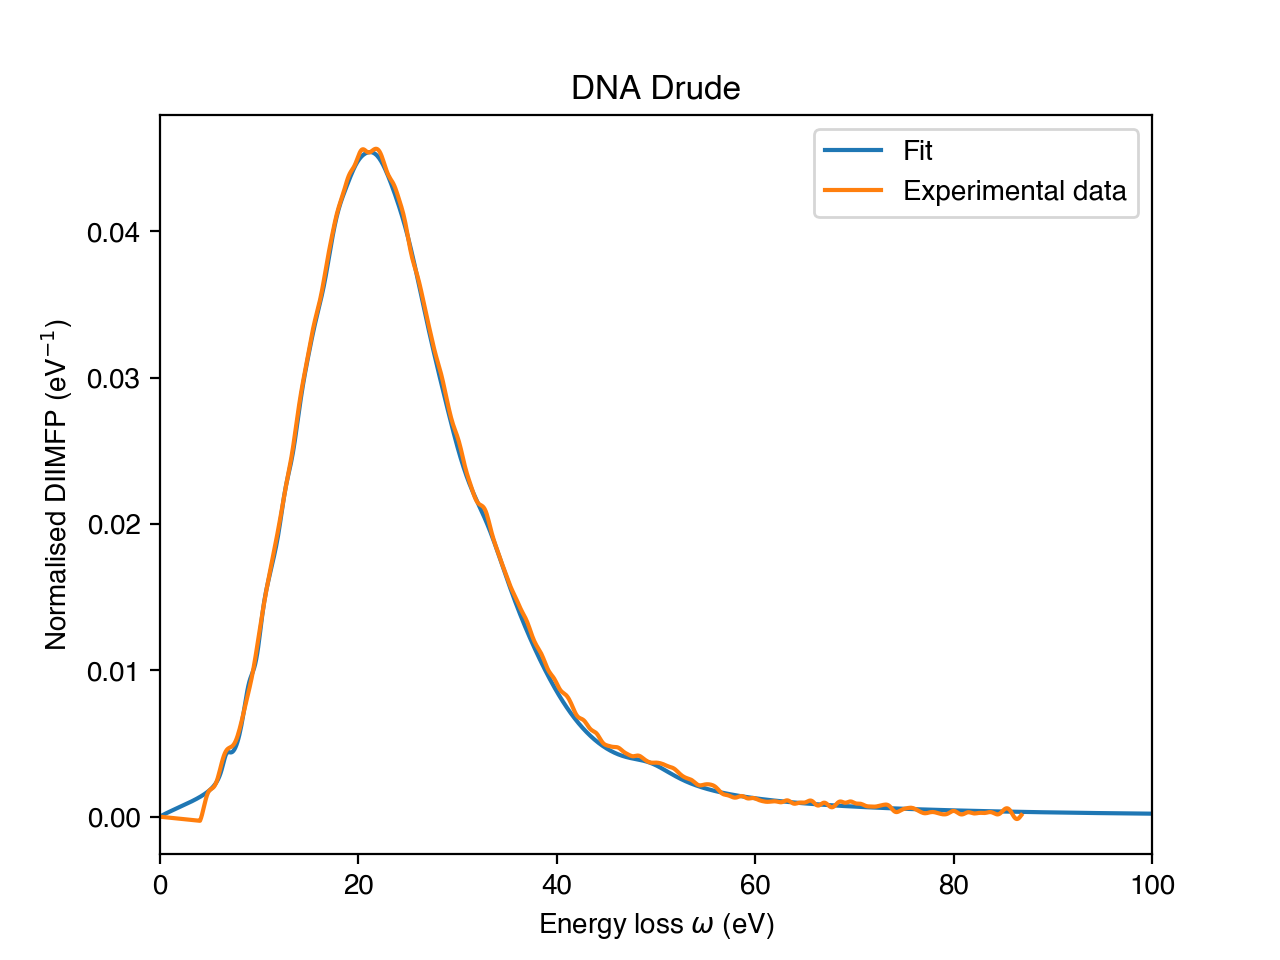

In [11]:
inelastic = osc.InelasticProperies(oscOptimised)
eloss, ndiimfp = inelastic.calculateDIIMFP(E0_global)

plt.figure()
plt.plot(eloss,ndiimfp,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

In [25]:
eps = eps_sum(oscOptimised)

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
energy_henke, elf_henke = mopt(oscOptimised.composition, oscOptimised.na)
ind_henke = energy_henke > 100
ind = oscOptimised.eloss <= 100
eloss = np.concatenate((oscOptimised.eloss[ind],energy_henke[ind_henke]))
elf = np.concatenate(((-1/eps[ind]).imag,elf_henke[ind_henke]))
# plt.plot(eloss,elf)
#=========================================================================

fsum = 1/(2*math.pi**2*(oscOptimised.na*a0**3))*np.trapz(eloss/h2ev*elf,eloss/h2ev)
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

div = elf/eloss
div[np.isnan(div)] = machine_eps
psum = 2/math.pi*np.trapz(div,eloss) + 1/oscOptimised.n_refrac**2
print('PSum = {}'.format(psum))

FSum = 4.204254421118829
Z = 4.85
PSum = 1.0023017138493493


In [76]:
# for attr in dir(oscOptimised):
#     print(attr, getattr(oscOptimised,attr))

<IPython.core.display.Javascript object>


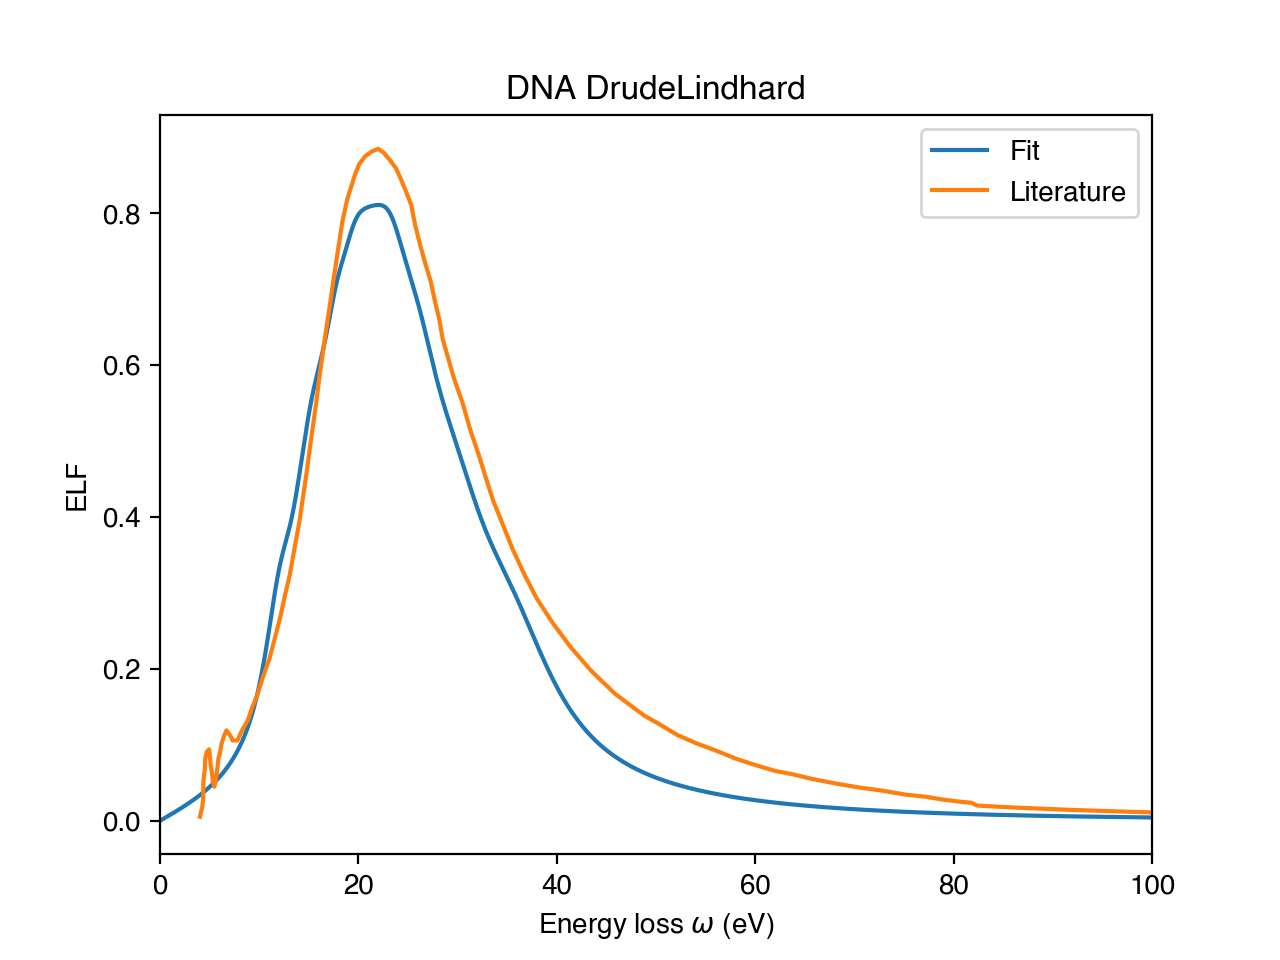

In [27]:
fd = pd.read_csv('../MATLAB/dna/dna_physdat_die.txt',header=None,sep=' ')
exp_elf = fd.values

plt.figure()
plt.plot(eloss,elf,label='Fit')
plt.plot(exp_elf[:,0],exp_elf[:,3],label='Literature')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscOptimised.name} {oscOptimised.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

In [66]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'DNA'
oscParams.composition = {'element': ['c','n','o','p','h'], 'index': [39,13,24,4,49]}
oscParams.A = np.array([2.91190143, 29.28595345, 25.39459091,  4.38294939, 26.70660796, 17.83453619, 29.46667292, 21.30507131, 24.20281585, 22.27543256, 20.54955451, 24.75853858, 29.70878012, 17.21958418, 58.68957981, 12.40544607, 29.78515434,  5.8898508])
oscParams.gamma = np.array([1.12318758,  1.91386584,  1.80797062,  1.70948,     2.43996841,  2.20239176,
  2.94245974,  3.50420615,  3.96559072,  4.9898142,   6.16482772, 15.18494182,
  8.48788462 , 7.88845456, 69.24172922,  6.89964465, 13.16478048,  6.76374932])
oscParams.omega = np.array([6.651554,    8.6855562,   9.86150577, 10.03722416, 11.00664193, 12.01568401,
 13.37981931, 14.99454178, 16.70308823, 18.87586383, 21.20834309, 22.63044684,
 24.39016239, 28.43776111, 31.0927594,  32.59410335, 37.29621955, 49.50454084])
oscParams.alpha = 0
oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.q = np.array([0])
oscParams.Eg = 4.5
oscParams.vb = 0.5
oscParams.na = 0.087
oscParams.ne = 0.2921
oscParams.n_refrac = 1.48
oscParams.Z = 4.85

In [6]:
oscParams_dl = Osc()
oscParams_dl.model = 'DrudeLindhard'
oscParams_dl.name = 'DNA'
oscParams_dl.composition = {'element': ['c','n','o','p','h'], 'index': [39,13,24,4,49]}
oscParams_dl.A = np.array([0.03707167, 0.06346206, 0.04169667, 0.02785981, 0.05248959, 0.05863788, 0.07132262, 0.05978291, 0.06272342, 0.05103643, 0.01738001])
oscParams_dl.gamma = np.array([3.83947842,  5.2545975,   5.54305166 , 3.57824441,  4.54088938,  5.76118693, 5.63924284,  6.57560893,  9.01357451, 11.74515, 44.3805188])
oscParams_dl.omega = np.array([12.2312972,  15.33470515, 16.29743744, 17.86284675, 19.68526635, 21.32315924, 23.3530618,  26.19175908, 29.87754852, 35.63394532, 46.47646071])
oscParams_dl.alpha = 0
oscParams_dl.eloss = linspace(machine_eps,100,0.1)
oscParams_dl.q = np.array([0])
oscParams_dl.Eg = 4.5
oscParams_dl.vb = 0.5
oscParams_dl.na = 0.087
oscParams_dl.ne = 0.2921
oscParams_dl.n_refrac = 1.48
oscParams_dl.Z = 4.85

In [72]:
d  = dict(A=np.round(oscParams.A,2), G=np.round(oscParams.gamma,2), Om = np.round(oscParams.omega,2), A_dl=np.round(oscParams_dl.A,3), G_dl=np.round(oscParams_dl.gamma,2), Om_dl = np.round(oscParams_dl.omega,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')
print(df.to_latex(index=False, header=False))

\begin{tabular}{rrrlll}
\toprule
  2.91 &   1.12 &   6.65 &  0.037 &   3.84 &  12.23 \\
 29.29 &   1.91 &   8.69 &  0.063 &   5.25 &  15.33 \\
 25.39 &   1.81 &   9.86 &  0.042 &   5.54 &   16.3 \\
  4.38 &   1.71 &  10.04 &  0.028 &   3.58 &  17.86 \\
 26.71 &   2.44 &  11.01 &  0.052 &   4.54 &  19.69 \\
 17.83 &   2.20 &  12.02 &  0.059 &   5.76 &  21.32 \\
 29.47 &   2.94 &  13.38 &  0.071 &   5.64 &  23.35 \\
 21.31 &   3.50 &  14.99 &   0.06 &   6.58 &  26.19 \\
 24.20 &   3.97 &  16.70 &  0.063 &   9.01 &  29.88 \\
 22.28 &   4.99 &  18.88 &  0.051 &  11.75 &  35.63 \\
 20.55 &   6.16 &  21.21 &  0.017 &  44.38 &  46.48 \\
 24.76 &  15.18 &  22.63 &        &        &        \\
 29.71 &   8.49 &  24.39 &        &        &        \\
 17.22 &   7.89 &  28.44 &        &        &        \\
 58.69 &  69.24 &  31.09 &        &        &        \\
 12.41 &   6.90 &  32.59 &        &        &        \\
 29.79 &  13.16 &  37.30 &        &        &        \\
  5.89 &   6.76 &  49.50 &      

**Irganox**

In [58]:
oscParams = Osc()
oscParams.model = 'Drude'
oscParams.name = 'Irganox'
oscParams.composition = {'element': ['c','o','h'], 'index': [73,12,108]}
oscParams.A = np.array([4.19,16.58,32.18,55.48,35.05,9.03,21.51,25.32,29.22,11.87,34.75,30.35,30.16,30.86,16.16])
oscParams.omega = np.array([6.2,9.6,11.4,13.6,16.2,18.3,19.7,22.0,25.4,30.0,30.6,38.0,46.6,56.7,72.9])
oscParams.gamma = np.array([0.7,2.3,3.3,4.1,4.2,3.2,5.3,6.2,8.0,14.5,11.5,13.7,14.3,16.5,14.0])
oscParams.alpha = 0
oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.q = np.array([0])
oscParams.Eg = 5.4
oscParams.vb = 10
oscParams.na = 0.113
oscParams.Z = 3.3
oscParams.ne = 0.278
oscParams.n_refrac = 1.4

In [68]:
oscParams = Osc()
oscParams.model = 'DrudeLindhard'
oscParams.name = 'Irganox'
oscParams.composition = {'element': ['c','o','h'], 'index': [73,12,108]}
oscParams.A = np.array([0.013,0.024,0.022,0.034,0.041,0.027,0.039,0.036,0.029,0.052,0.011,0.027,0.028,0.032,0.034,0.039,0.026,0.009])
oscParams.omega = np.array([6.36,10.4,12.42,14.49,16,17.34,18.96,20.47,21.81,23.44,25.11,26.6,28.72,31.73,35.99,41.09,48.01,57.08])
oscParams.gamma = np.array([0.62,2.75,2.38,2.91,3.33,2.23,2.68,3.01,3.13,3.95,2.79,3.99,5.79,7.61,16.11,32.31,27.78,99.65])
oscParams.alpha = 0
oscParams.eloss = linspace(machine_eps,100,0.1)
oscParams.q = np.array([0])
oscParams.Eg = 5.4
oscParams.vb = 10
oscParams.na = 0.113
oscParams.Z = 3.3
oscParams.ne = 0.278
oscParams.n_refrac = 1.4

In [69]:
eps = eps_sum(oscParams)

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
energy_henke, elf_henke = mopt(oscParams.composition, oscParams.na)
ind_henke = energy_henke > 100
ind = oscParams.eloss <= 100
eloss = np.concatenate((oscParams.eloss[ind],energy_henke[ind_henke]))
elf = np.concatenate(((-1/eps[ind]).imag,elf_henke[ind_henke]))
#=========================================================================

print(f'Model: {oscParams.model}')

fsum = 1/(2*math.pi**2*(oscParams.na*a0**3))*np.trapz(eloss/h2ev*elf,eloss/h2ev)
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscParams.Z))

div = elf/eloss
div[np.isnan(div)] = machine_eps
psum = 2/math.pi*np.trapz(div,eloss) + 1/oscParams.n_refrac**2
print('PSum = {}'.format(psum))

Model: DrudeLindhard
FSum = 3.095761984016654
Z = 3.3
PSum = 1.0333610538737539


<IPython.core.display.Javascript object>


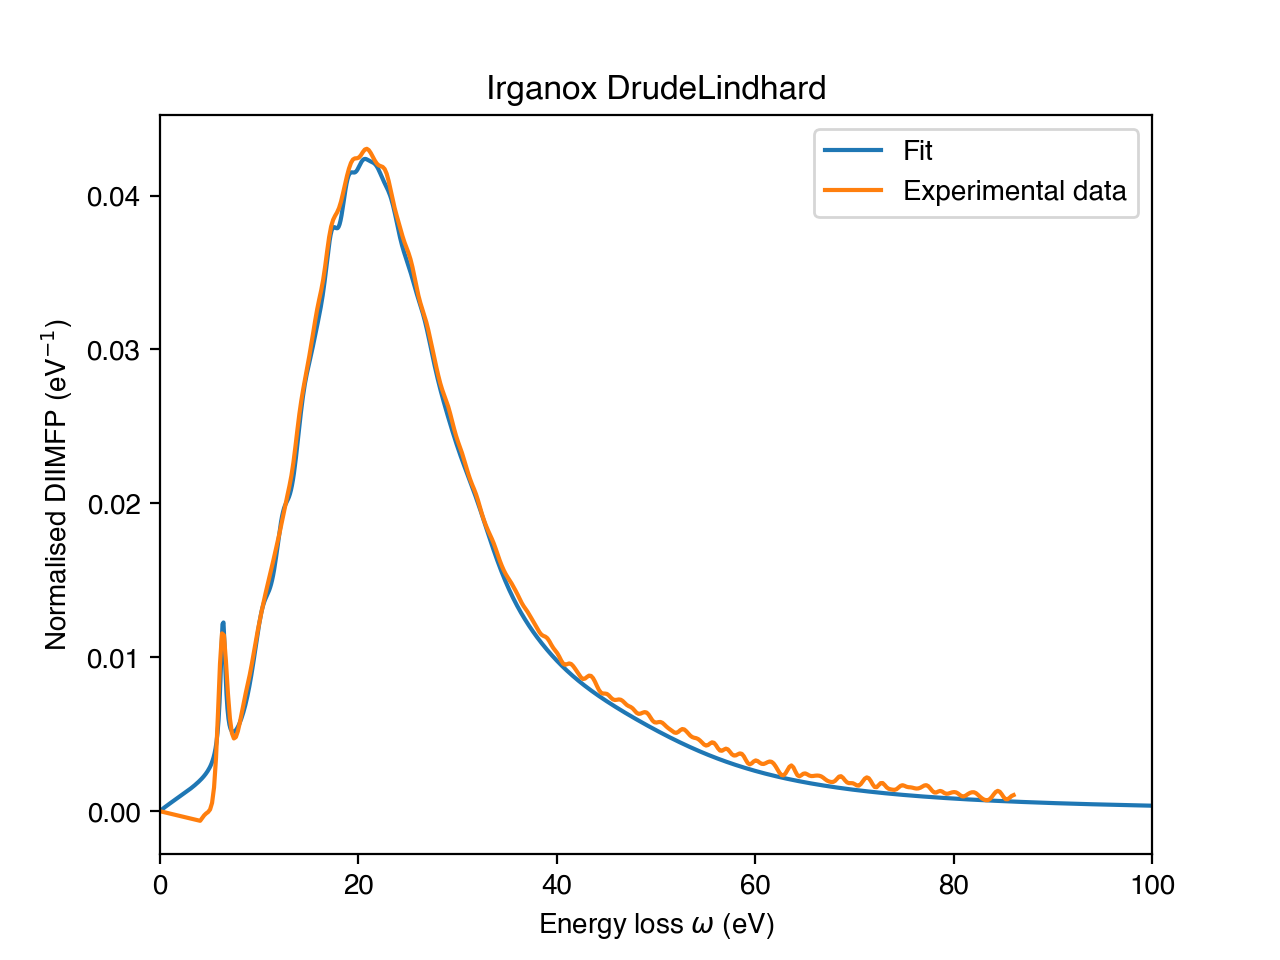

In [11]:
E0 = 1600 
eloss, w = diimfp(oscParams, E0, 11)
w_normalised = w / np.trapz(w, eloss)

fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(exp_diimfp[:,0],exp_diimfp[:,1],label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

In [60]:
fd = pd.read_csv(f'diimfp/{oscParams.name}_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

In [70]:
osc_min_A = np.ones_like(oscParams.A)*1e-10
osc_min_gamma = np.ones_like(oscParams.gamma)*0.25
osc_min_omega = np.ones_like(oscParams.omega)*oscParams.Eg

if oscParams.model == 'Drude':
    osc_max_A = np.ones_like(oscParams.A)*1e3
else:
    osc_max_A = np.ones_like(oscParams.A)
    
osc_max_gamma = np.ones_like(oscParams.gamma)*100
osc_max_omega = np.ones_like(oscParams.omega)*x_exp[-1]

lb = np.hstack((osc_min_A,osc_min_gamma,osc_min_omega))
ub = np.hstack((osc_max_A,osc_max_gamma,osc_max_omega))

In [71]:
opt = nlopt.opt(nlopt.LN_COBYLA, len(struct2Vec(oscParams)))
opt.set_min_objective(f)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)
opt.add_inequality_constraint(fc)
opt.set_maxeval(1000)
opt.set_xtol_rel(1e-6)

In [72]:
xopt = opt.optimize(struct2Vec(oscParams))
# xopt = opt.optimize(struct2Vec(oscOptimised))

oscOptimised = vec2Struct(xopt)

In [73]:
print('A: ' + np.array2string(oscOptimised.A, separator=', ', max_line_width = 500))
print('gamma: ' + np.array2string(oscOptimised.gamma, separator=', ', max_line_width = 500))
print('omega: ' + np.array2string(oscOptimised.omega, separator=', ', max_line_width = 500))

A: [0.01169139, 0.02271088, 0.02143335, 0.03060899, 0.03862816, 0.02569452, 0.03447278, 0.03429248, 0.0276332 , 0.05136845, 0.01023538, 0.02538899, 0.02528762, 0.03018578, 0.03185526, 0.03671311, 0.02431549, 0.00727974]
gamma: [ 0.61611111,  2.78528199,  2.3648203 ,  2.88153479,  3.29586187,  2.15499836,  2.63883616,  3.02429155,  3.66545219,  4.28015724,  2.80800401,  4.35195794,  5.77975304,  7.68335318, 15.69692322, 31.47253437, 26.63819315, 99.65454084]
omega: [ 6.41166252, 10.57114427, 12.5475569 , 14.58689544, 16.03287674, 17.40999936, 19.02195679, 20.53719895, 21.95592531, 23.37473936, 25.14195731, 26.59447504, 28.5850239 , 31.58308416, 35.95335094, 41.15729662, 48.62514015, 56.0392724 ]


<IPython.core.display.Javascript object>


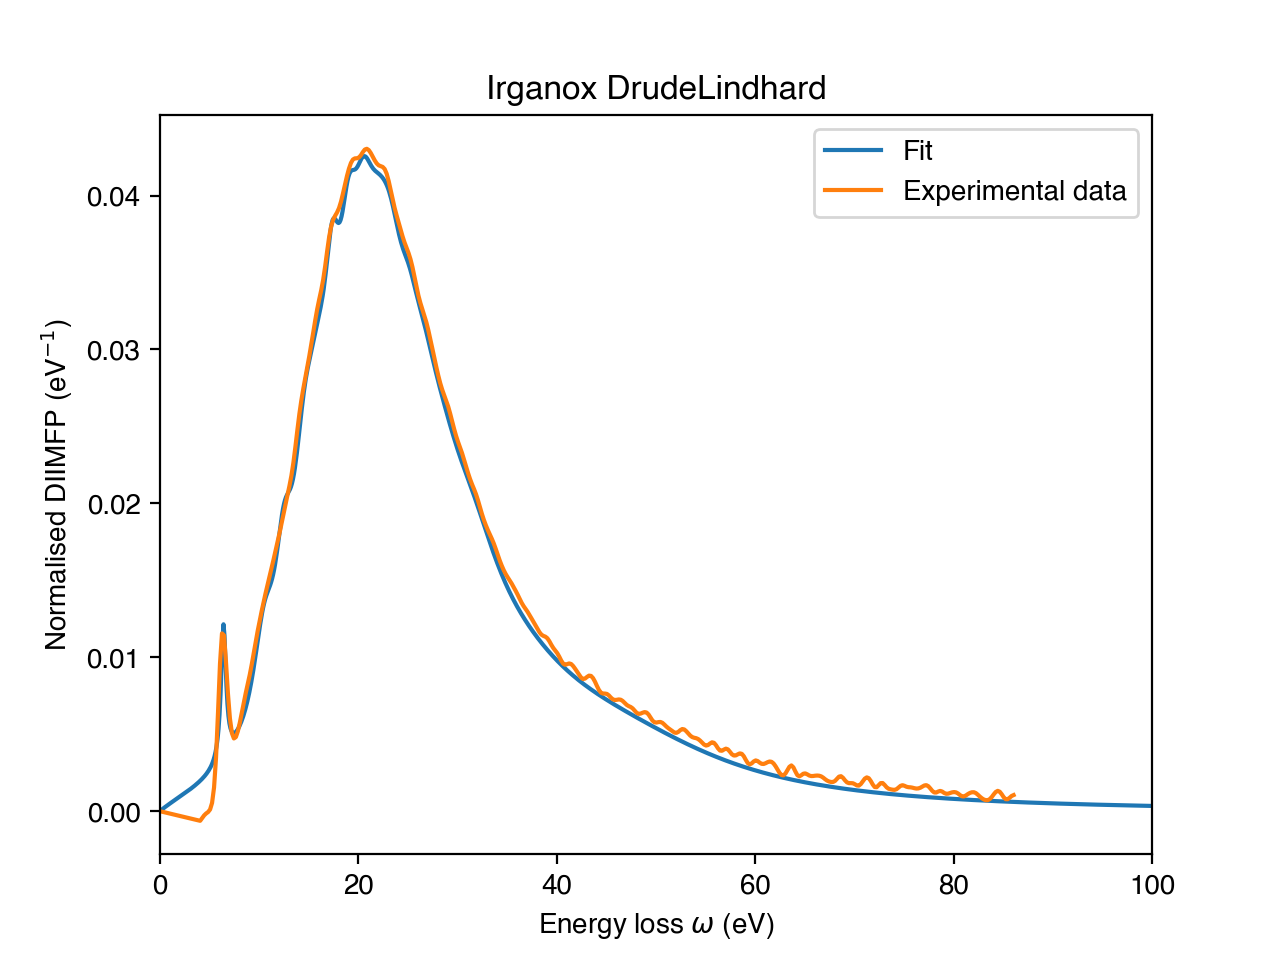

In [74]:
E0 = 1600 
eloss, w = diimfp(oscOptimised, E0, 12)
w_normalised = w / np.trapz(w, eloss)

plt.figure()
plt.plot(eloss,w_normalised,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.legend()
plt.xlim(0,100)
plt.show()

In [75]:
eps = eps_sum(oscOptimised)

# extending the ELF with the Henke ionisation data to higher energy losses
#=========================================================================
energy_henke, elf_henke = mopt(oscOptimised.composition, oscOptimised.na)
ind_henke = energy_henke > 100
ind = oscOptimised.eloss <= 100
eloss = np.concatenate((oscOptimised.eloss[ind],energy_henke[ind_henke]))
elf = np.concatenate(((-1/eps[ind]).imag,elf_henke[ind_henke]))
#=========================================================================

print(f'Model: {oscOptimised.model}')

fsum = 1/(2*math.pi**2*(oscOptimised.na*a0**3))*np.trapz(eloss/h2ev*elf,eloss/h2ev)
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

div = elf/eloss
div[np.isnan(div)] = machine_eps
psum = 2/math.pi*np.trapz(div,eloss) + 1/oscOptimised.n_refrac**2
print('PSum = {}'.format(psum))

Model: DrudeLindhard
FSum = 2.9670140592778953
Z = 3.3
PSum = 1.000356023985887


<IPython.core.display.Javascript object>


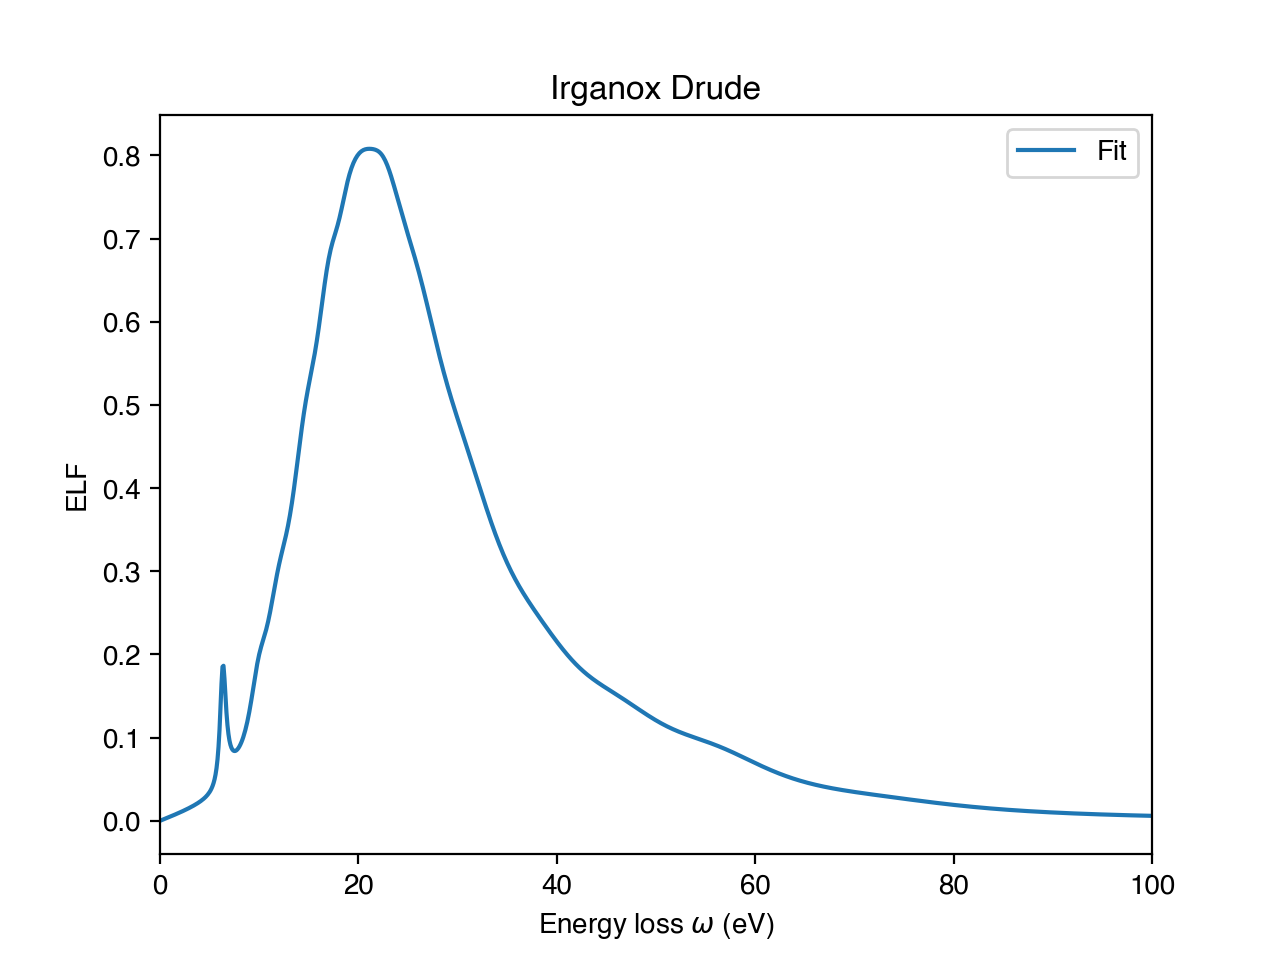

In [51]:
plt.figure()
plt.plot(eloss,elf,label='Fit')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
plt.title(f'{oscParams.name} {oscParams.model}')
plt.xlim(0,100)
plt.legend()
plt.show()

In [76]:
if oscOptimised.model == 'Drude':
    oscDrude = copy.deepcopy(oscOptimised)
elif oscOptimised.model == 'DrudeLindhard':
    oscDL = copy.deepcopy(oscOptimised)

In [77]:
d  = dict(A=np.round(oscDrude.A,2), G=np.round(oscDrude.gamma,2), Om = np.round(oscDrude.omega,2), A_dl=np.round(oscDL.A,3), G_dl=np.round(oscDL.gamma,2), Om_dl = np.round(oscDL.omega,2))
df = pd.DataFrame.from_dict(d, orient='index').transpose().fillna('')
print(df.to_latex(index=False, header=False))

\begin{tabular}{lllrrr}
\toprule
   4.3 &   0.71 &   6.19 &  0.012 &   0.62 &   6.41 \\
 16.63 &   2.28 &   9.63 &  0.023 &   2.79 &  10.57 \\
 33.28 &   3.19 &   11.4 &  0.021 &   2.36 &  12.55 \\
 57.19 &    4.1 &  13.58 &  0.031 &   2.88 &  14.59 \\
 35.18 &   4.14 &  16.13 &  0.039 &   3.30 &  16.03 \\
  9.31 &   3.22 &  18.29 &  0.026 &   2.15 &  17.41 \\
 21.68 &   5.32 &  19.69 &  0.034 &   2.64 &  19.02 \\
 25.28 &   6.18 &  21.94 &  0.034 &   3.02 &  20.54 \\
  29.1 &      8 &  25.42 &  0.028 &   3.67 &  21.96 \\
 11.81 &   14.8 &  29.88 &  0.051 &   4.28 &  23.37 \\
 34.91 &  11.39 &  30.57 &  0.010 &   2.81 &  25.14 \\
 30.27 &  13.48 &  38.14 &  0.025 &   4.35 &  26.59 \\
 27.04 &  14.41 &  46.45 &  0.025 &   5.78 &  28.59 \\
 31.13 &  16.82 &  56.38 &  0.030 &   7.68 &  31.58 \\
 16.23 &  24.15 &  73.06 &  0.032 &  15.70 &  35.95 \\
       &        &        &  0.037 &  31.47 &  41.16 \\
       &        &        &  0.024 &  26.64 &  48.63 \\
       &        &        &  0.00